# TODO
- [ ] Rerun for 100 params for > 300 simulations reach (to fill up rank histogram)
- [x] Implement CRPS for example
- [x] Run RMSE for example

# Best Calibration Day

In the context of ensemble Kalman filters methods such at the ensemble adjustment Kalman filter (EAKF), calibration refers to the degree to which the filter's statistical estimates match the true underlying statistics of the system being observed and modeled. Good calibration in an EAKF means that the probabilistic predictions produced by the filter accurately represent the true uncertainty in the system's state. This entails two key aspects:

1. **Reliability**: The ensemble spread should reflect the true uncertainty of the system. If the filter is well-calibrated, the observed values should, over time, fall within the predicted ranges (e.g., confidence intervals) at a rate consistent with the stated probabilities. For example, in a perfectly calibrated system, if the ensemble filter indicates a 90% credible interval for a particular variable, then the true value of that variable should fall within this range 90% of the time.

2. **Bias**: A well-calibrated EAKF should have minimal bias in its posterior. This means that, on average, the ensemble mean (or median, depending on the distribution) should be close to the true mean of the system's state. There should be no systematic overestimation or underestimation of the true state by the filter.

This notebook attempts to answer the following question.


**Question:** Is there an optimal day in the time-series where the calibration is optimal?

For each day, we investigate the following diagnostic tools and metrics that assess calibration:
1. **Rank-Histogram**
    
    Rank histograms, also known as Talagrand diagrams, are used to evaluate the calibration of a filter. To create the rank histogram, for each observational data point:

    - Insert the observation into the ordered sequence of the ensemble values.
    - Record the rank of the observation within this sequence.
    
    \
    If the filter is perfectly calibrated, the rank histogram should be flat, indicating that the observations are equally likely to fall in any place within the sorted ensemble. A U-shaped histogram suggests underdispersion (the filter is too confident), while a hill-shaped (inverted U) histogram indicates overdispersion (the ensemble is not confident enough). Skewness in the histogram suggests a bias in the filter.

2. **Reliability Plot**

    Reliability plots compare the filter probabilities against the observed frequencies for different probabilistic bins. In a reliability plot, the perfect reliability line is a 45-degree diagonal line. Points above the line indicate underforecasting (events were more likely than predicted), and points below the line indicate overforecasting (events were less likely than predicted). The closer the plotted points are to the diagonal, the more reliable the filter.
    
3. **Continuous Ranked Probability Score (CRPS)**

    The Continuous Ranked Probability Score (CRPS) is a commonly used proper scoring rule for evaluating the accuracy of probabilistic predictions. It measures the difference between the prediction cumulative distribution function (CDF) and the observed CDF, summed across all possible values. The CRPS is especially useful for ensemble predictions because it can directly use the ensemble members to construct the prediction CDF. A lower CRPS indicates a better filter, with a CRPS of 0 indicating a perfect prediction. It is defined as
    $$
    C R P S(F, y)=\int_{\mathbb{R}}(F(x)-\mathbb{1}_{x \geq y})^2 d x
    $$
    where $F$ is the prediction cumulative distribution function $y \in \mathbb{R}$ is the observation.
    \
    Reference: https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf
4. **RMSE**
    

Rerun for only 100 parameter scenarios since it takes FOREVER to do the full set. We will rerun for full set of parameters if there's anything interesting here...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import pickle
from tqdm import tqdm

from epyfilter import posterior_checks


## Run for one example parameter scenario

In [2]:
# choose one param as an example
param_list = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/good_param_list.csv")
pp = param_list.iat[42365, 0]
print(pp)

6115


In [3]:
# read in last epidemic days and peak
compute_days_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/compute_days.csv")
compute_days_df.loc[compute_days_df.param == pp]

param  late_day  peak1  peak2  last_epi_day
42365   6115       178     62    213           274

In [4]:
# directory has pkls saved for each 100 runs (ran this for potential example plots for the paper before)
run_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"

def open_pickle(pickle_file):
    with open(f"{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data

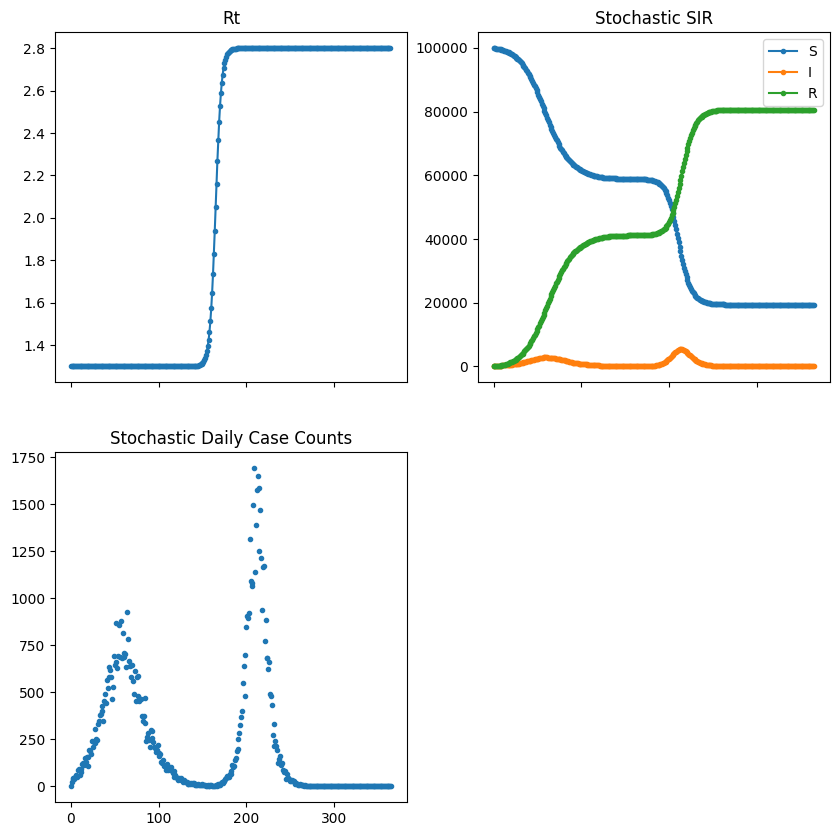

In [5]:
#plot sythentic data for run 0
file = run_dir + f"{pp}_adaptive_inflation_run_0.pkl"
eakf = open_pickle(file)

eakf.data.plot_all()

In [6]:
# calculate rank, percentiles, and cdfs
rank = np.zeros((100, 365))
percentiles = np.zeros((100, 365))

for run in tqdm(range(100)):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    
    truth = eakf.data.beta * eakf.data.t_I
    post_rts = np.sort(np.array([θ.beta * θ.t_I for θ in eakf.θ_list]), axis=1)
    
    # find which index in ensemble post_rts[i-1,:] <= truth[:] < post_rts[i,:]
    idx = (post_rts.T < truth).sum(axis=0)
    
    rank[run,:] = idx

    # map from index to percentile p (smallest one where truth lives within p% CrI)
    # each ensemble member has mass 1 / eakf.m
    # for cases where the truth does not lie within idx = 0 or idx = n_ens
    n_ens = eakf.m
    percentiles[run,:] = np.maximum(1 - 2*idx/n_ens, 2*idx/n_ens - 1)  # each ensemble member has mass 1 / n_ens


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.50it/s]


### 1. Rank Histogram

A rank of 0 means that all ensemble members were strictly greater than the observation. A rank of 300 (`n_{ens} = eakf.m`) means that all ensemble members were strictly less than the observation. To determine which day $t$ has the most uniform rank histogram, we compute the following score:
$$
\operatorname{SCORE}_t = \sum_{i=0}^{n_{ens}} \left|~r_t(i) - \frac{n_{runs}}{n_{ens} + 1} \right|
$$
where $r_t(i)$ is the number of runs that had a rank of $i$ on day $t$.

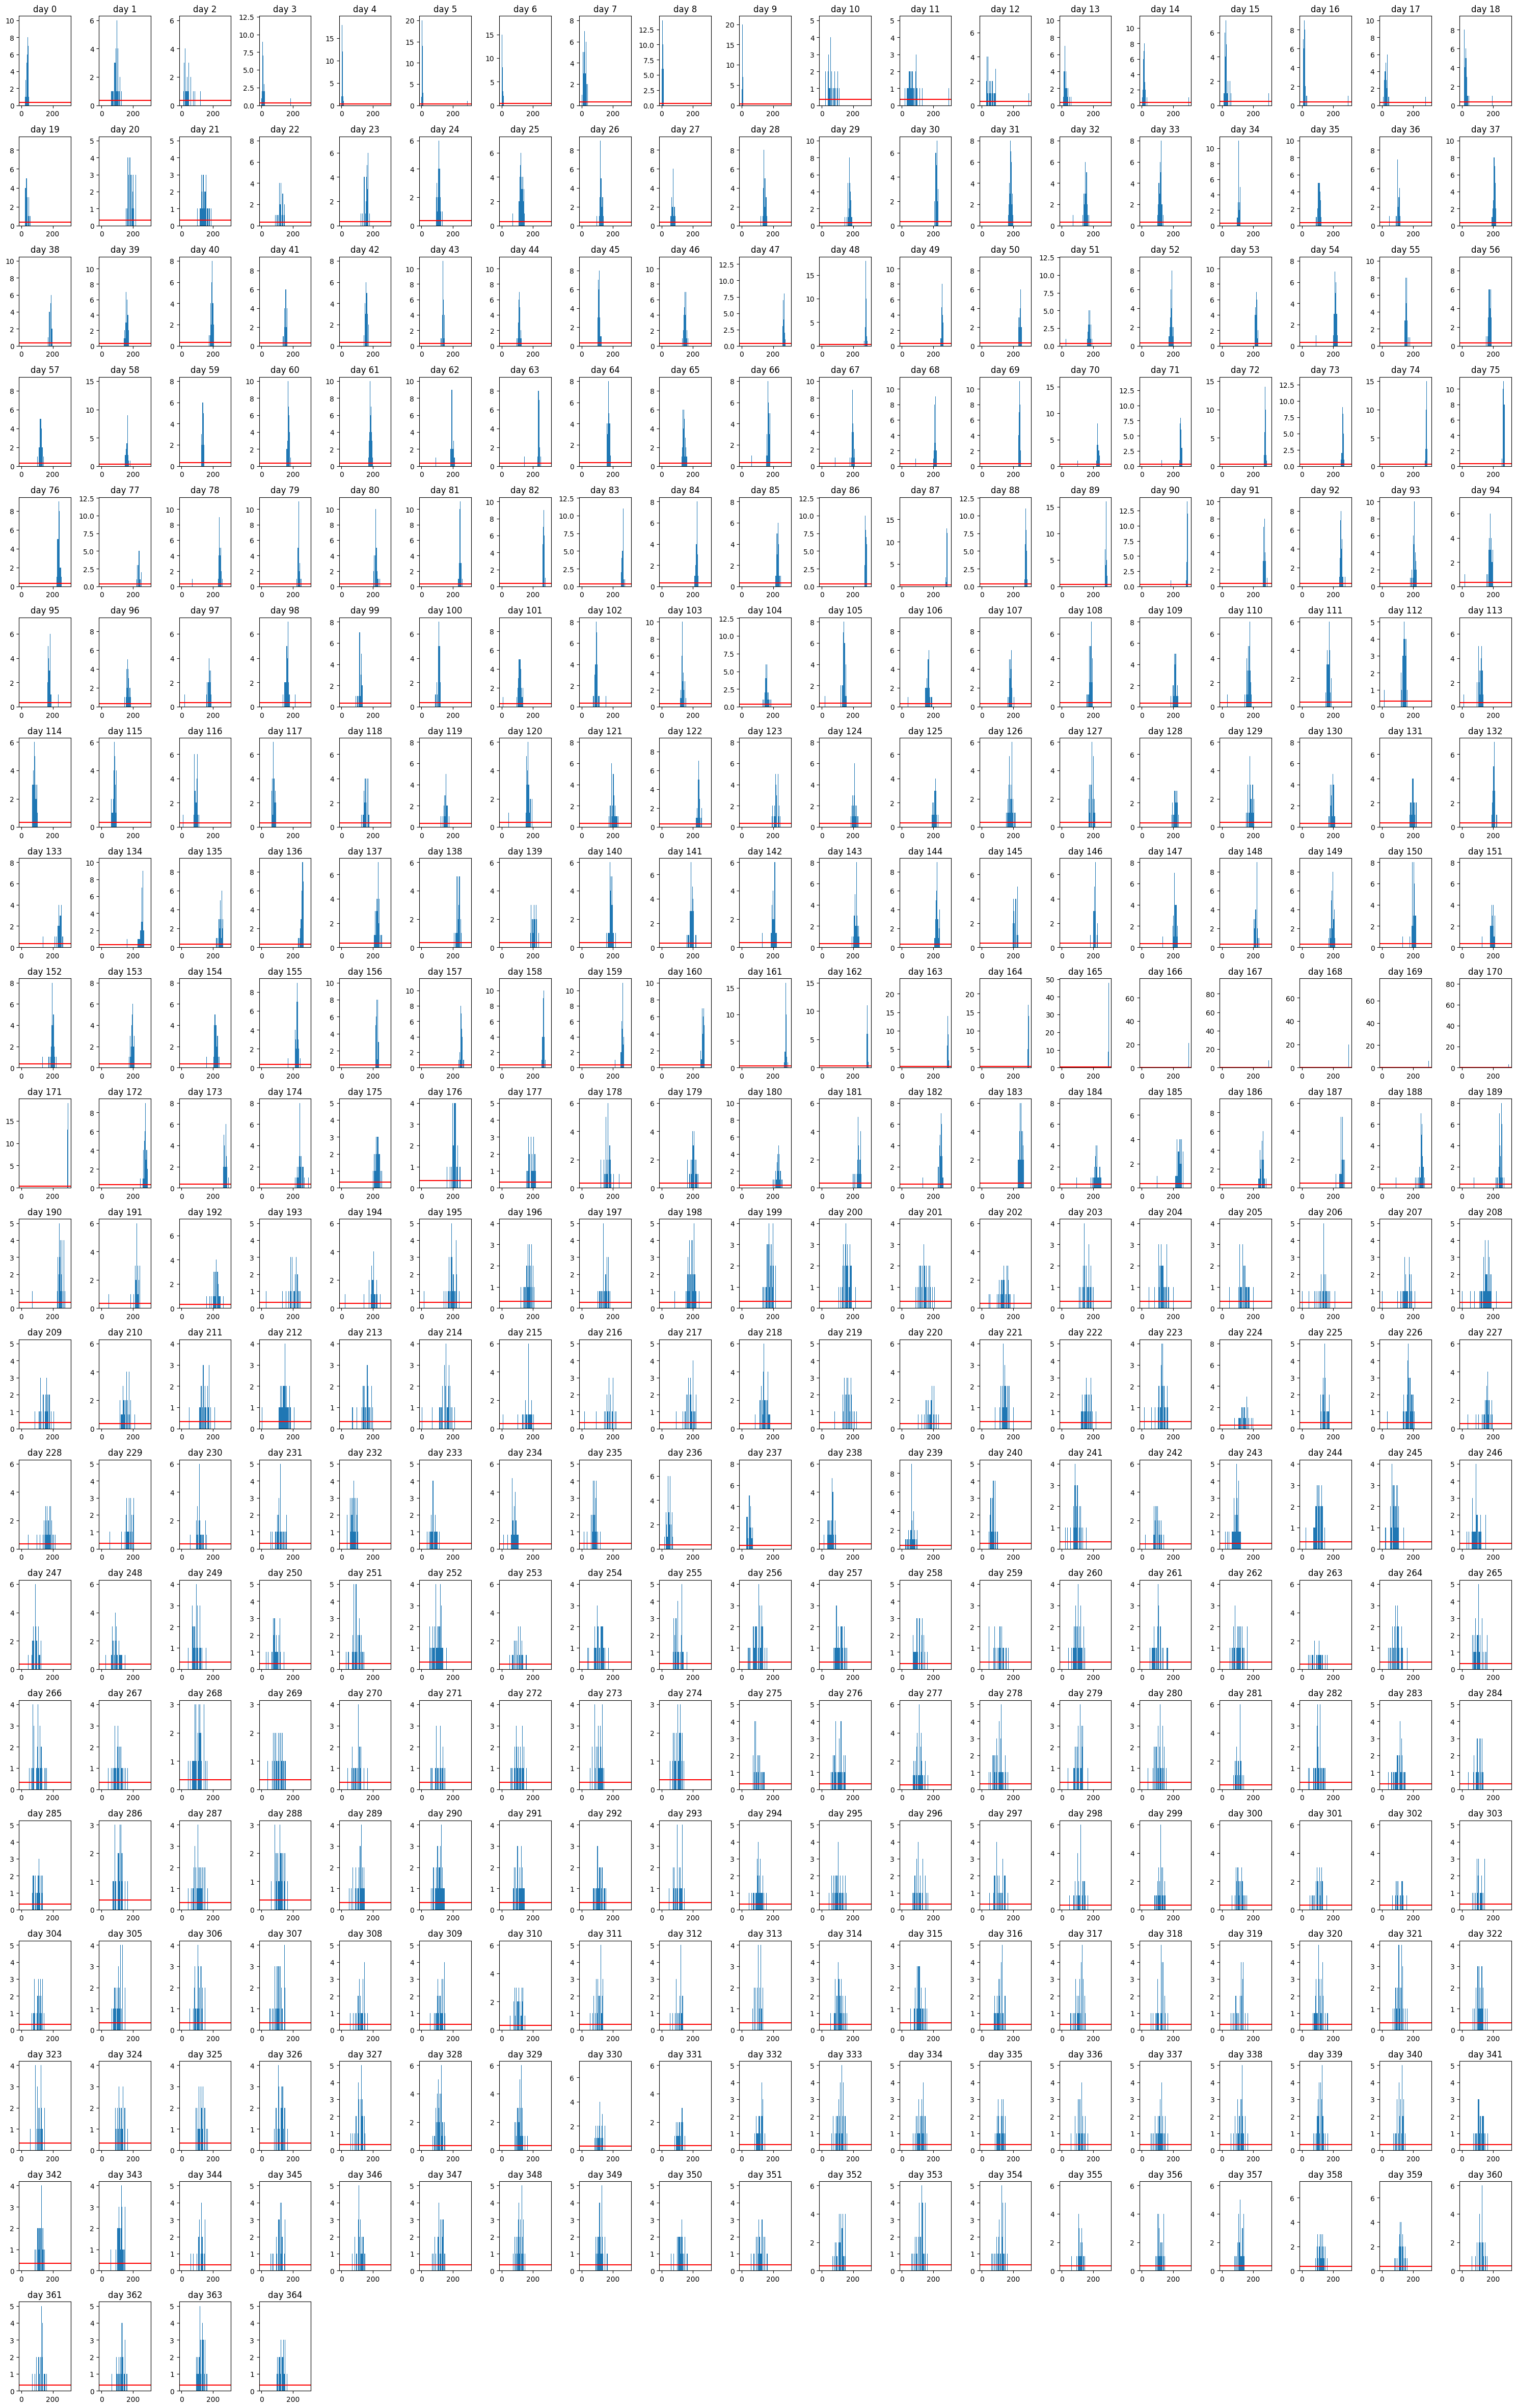

In [7]:
p_list = np.arange(.025, 1, .025)

nrow = 20
ncol = 19
fig_width = 30
fig_height = fig_width * (nrow / ncol) * 1.5

fig, axs = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height))

n_ens = eakf.m
n_runs = 100

scores = []
for i, ax in enumerate(axs.flat):
    if i > 364:
        ax.axis("off")
    else:
        hist = ax.hist(rank[:,i], bins=np.arange(0, eakf.m + 1))
        ax.axhline(y = n_runs/eakf.m, color = 'r', linestyle = '-')  # uniform line
        ax.set_title(f"day {i}")
        # compute rank histogram score
        scores.append(np.sum(np.abs(hist[0] - n_runs/(eakf.m + 1))))

plt.tight_layout()
plt.show()

In [8]:
np.argsort(scores)[:5]

array([262, 261, 252, 267, 279])

### 2. Reliability plot
To determine which day  $t$ has the reliabilty plot closest to the identity line we compute the residual sum of squares:
$$
\operatorname{SCORE}_t = \sum_{i=1}^n (p(i) - f_t(p(i)))^2
$$
where $p(i) = 2 (i-1)/n_{ens}$ is the credible level $(0 \leq p_i \leq 1)$ and $f_t$ is the fraction of runs where the truth lies within the $p_i$-th credible interval on day $t$.

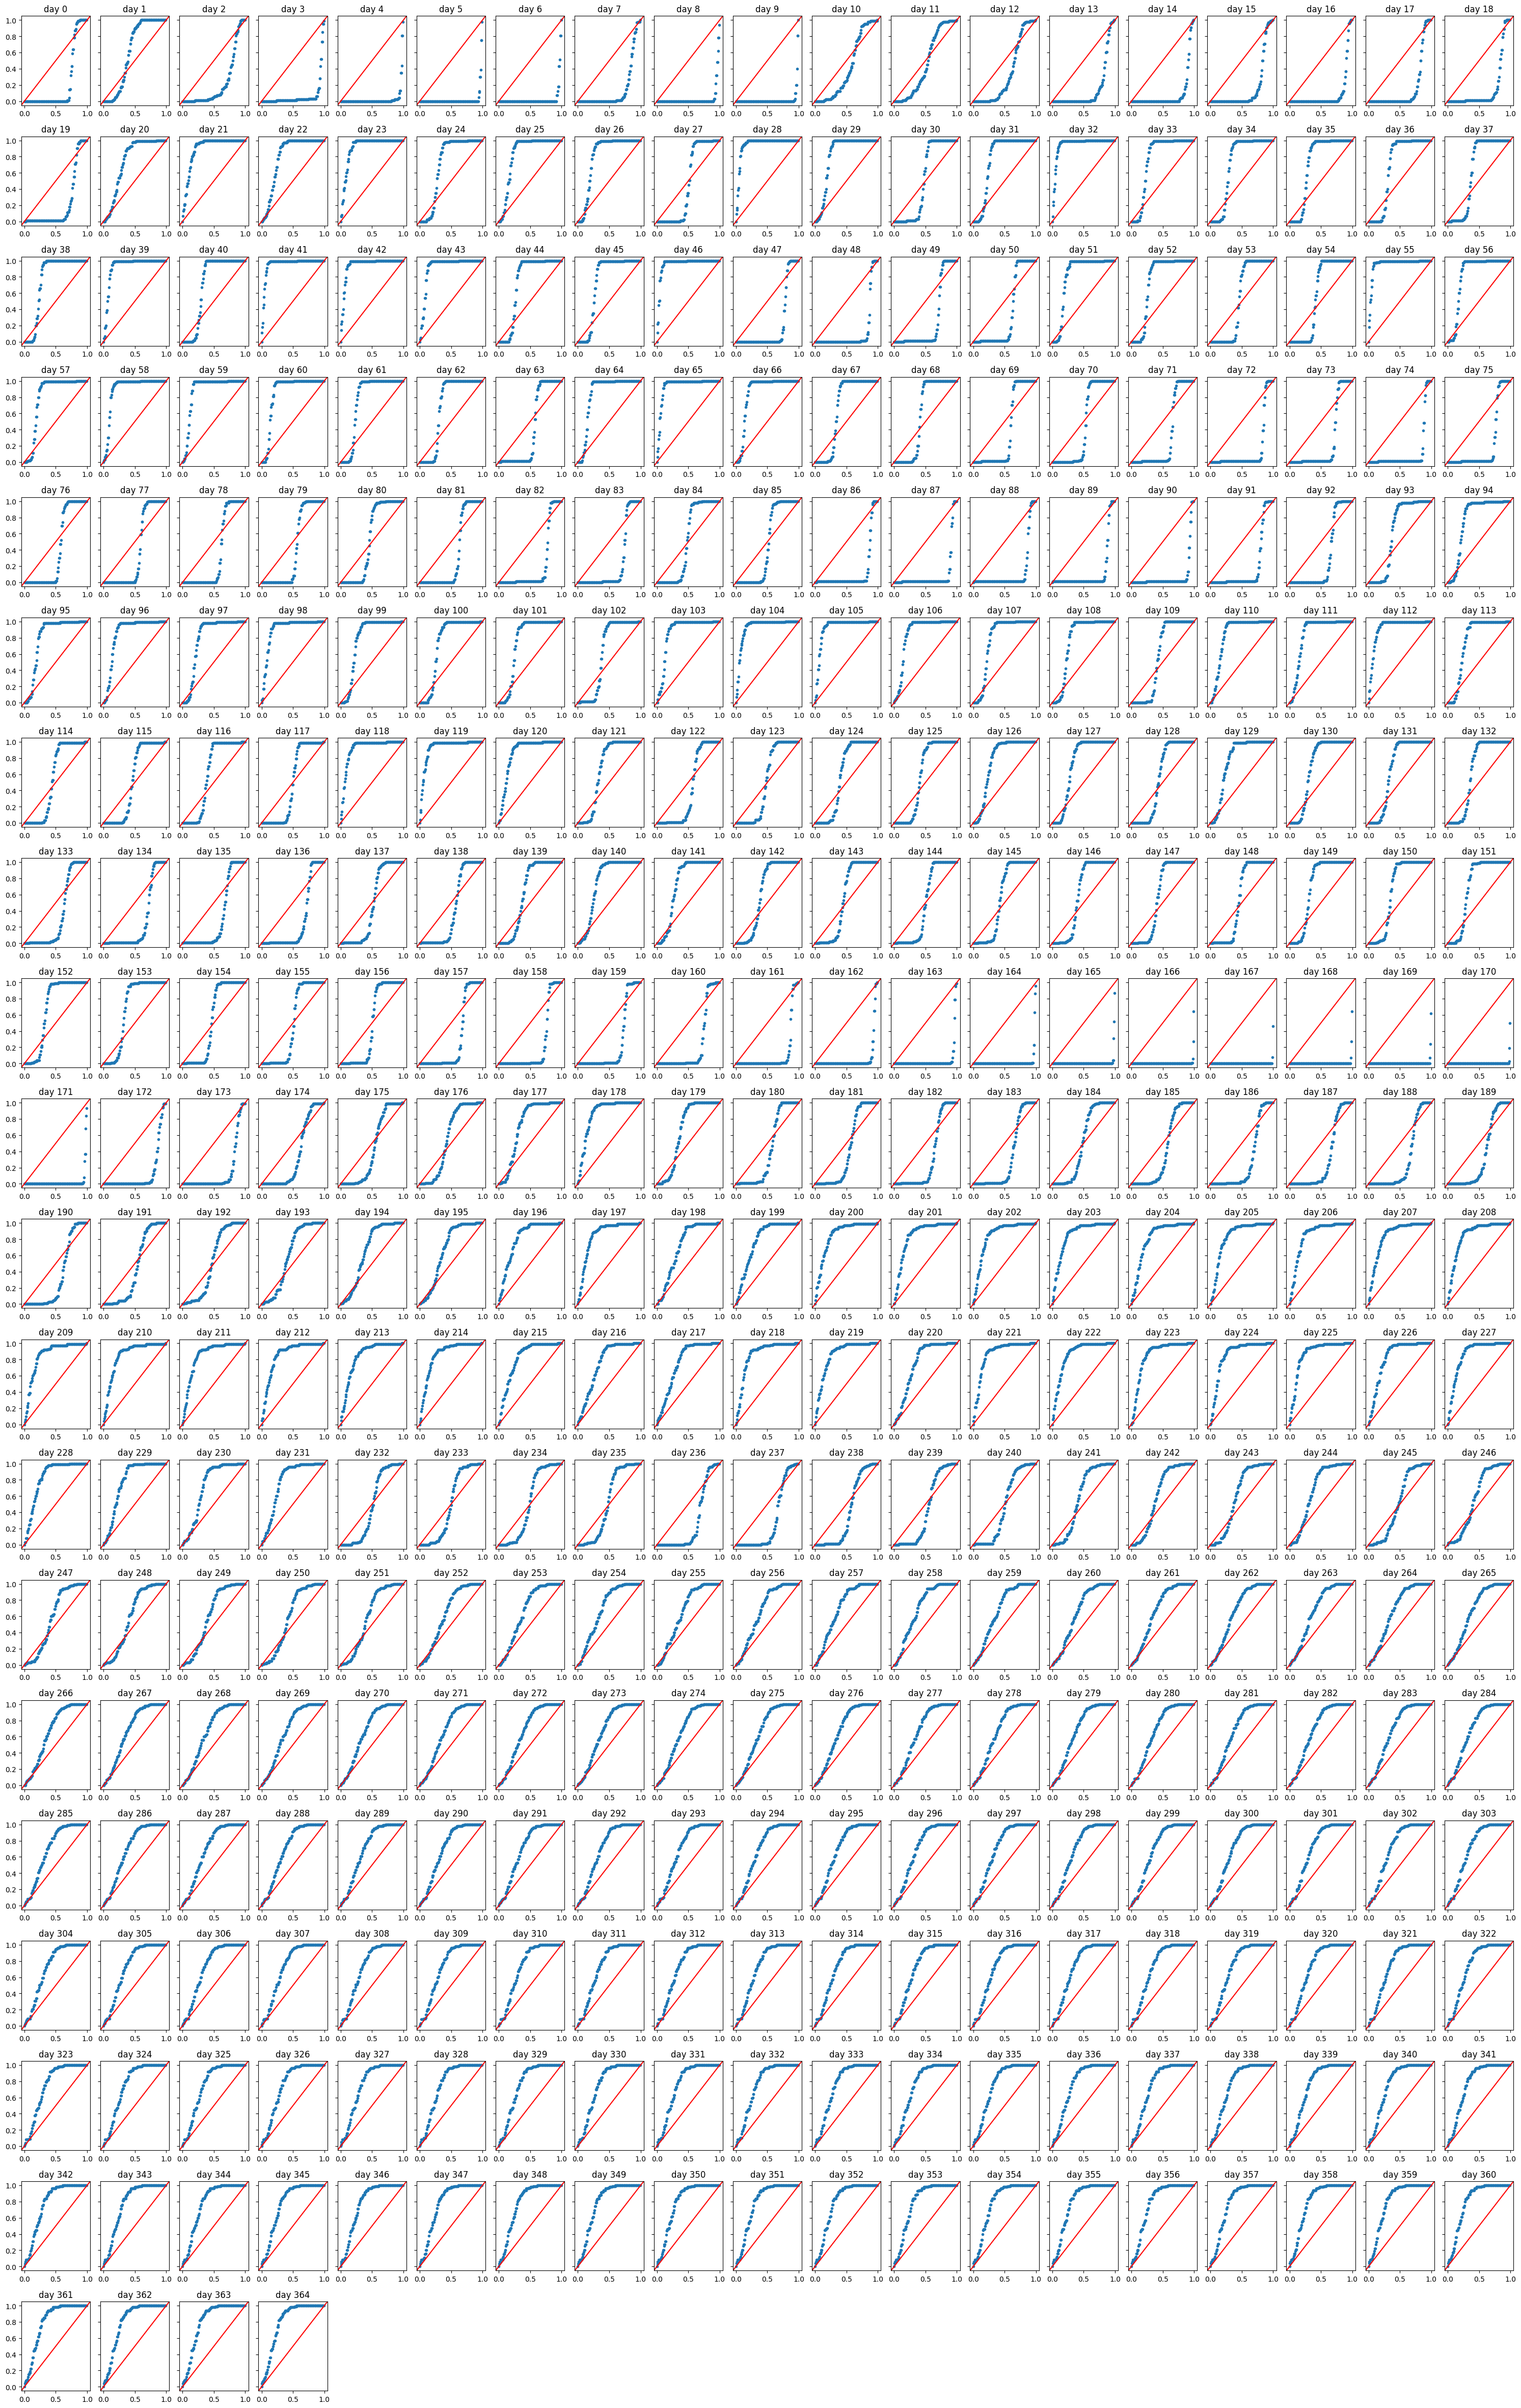

In [23]:
n_ens = eakf.m
p_list = np.arange(0, 1, 2/n_ens)

nrow = 20
ncol = 19
fig_width = 30
fig_height = fig_width * (nrow / ncol) * 1.5

fig, axs = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height), sharey=True)

scores = []
for i, ax in enumerate(axs.flat):
    if i > 364:
        ax.axis("off")
    else:
        cdf = np.cumsum(np.histogram(percentiles[:,i], bins=p_list)[0]/100)
        cdf = np.insert(cdf, 0, 0.)
        ax.plot(p_list, cdf, '.')
        ax.axline((0, 0), (1, 1), color='r')
        ax.set_title(f"day {i}")
        scores.append(np.mean((p_list - cdf) ** 2))

plt.tight_layout()
plt.show()

In [24]:
np.argsort(np.array(scores))[:5]

array([ 11, 245,  10, 247, 246])

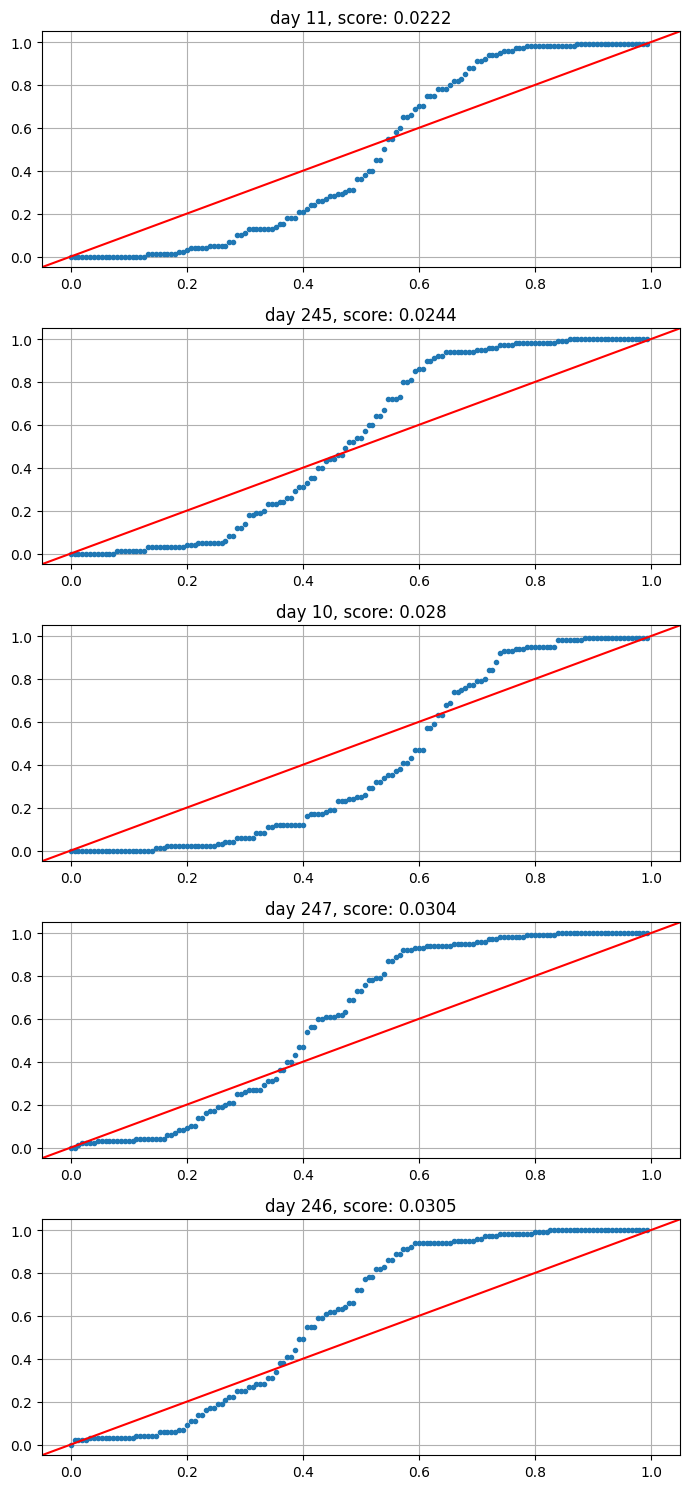

In [25]:
best_scores_idx = np.argsort(np.array(scores))[:5]

fig, axs = plt.subplots(5, figsize=(7, 15))
for i, ax in enumerate(axs.flat):
    ax.plot(p_list, [(percentiles[:,best_scores_idx[i]] < p).sum() / 100 for p in p_list], '.')
    ax.axline((0, 0), (1, 1), color='r')
    ax.set_title(f"day {best_scores_idx[i]}, score: {round(scores[best_scores_idx[i]], 4)}")
    ax.grid()

plt.tight_layout()
plt.show()

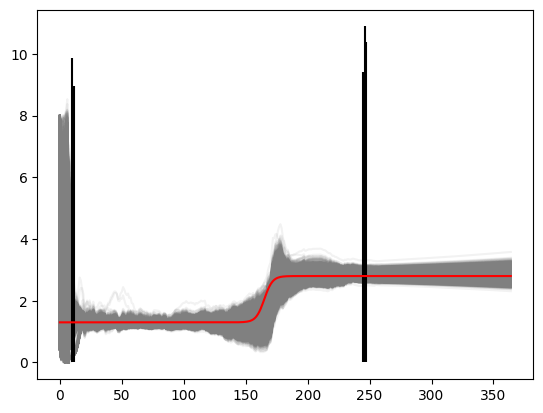

In [26]:
fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.1)

for day in best_scores_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='black', label='last epi day')
ax.plot(truth, color='r')

In [27]:
blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_idx,:])

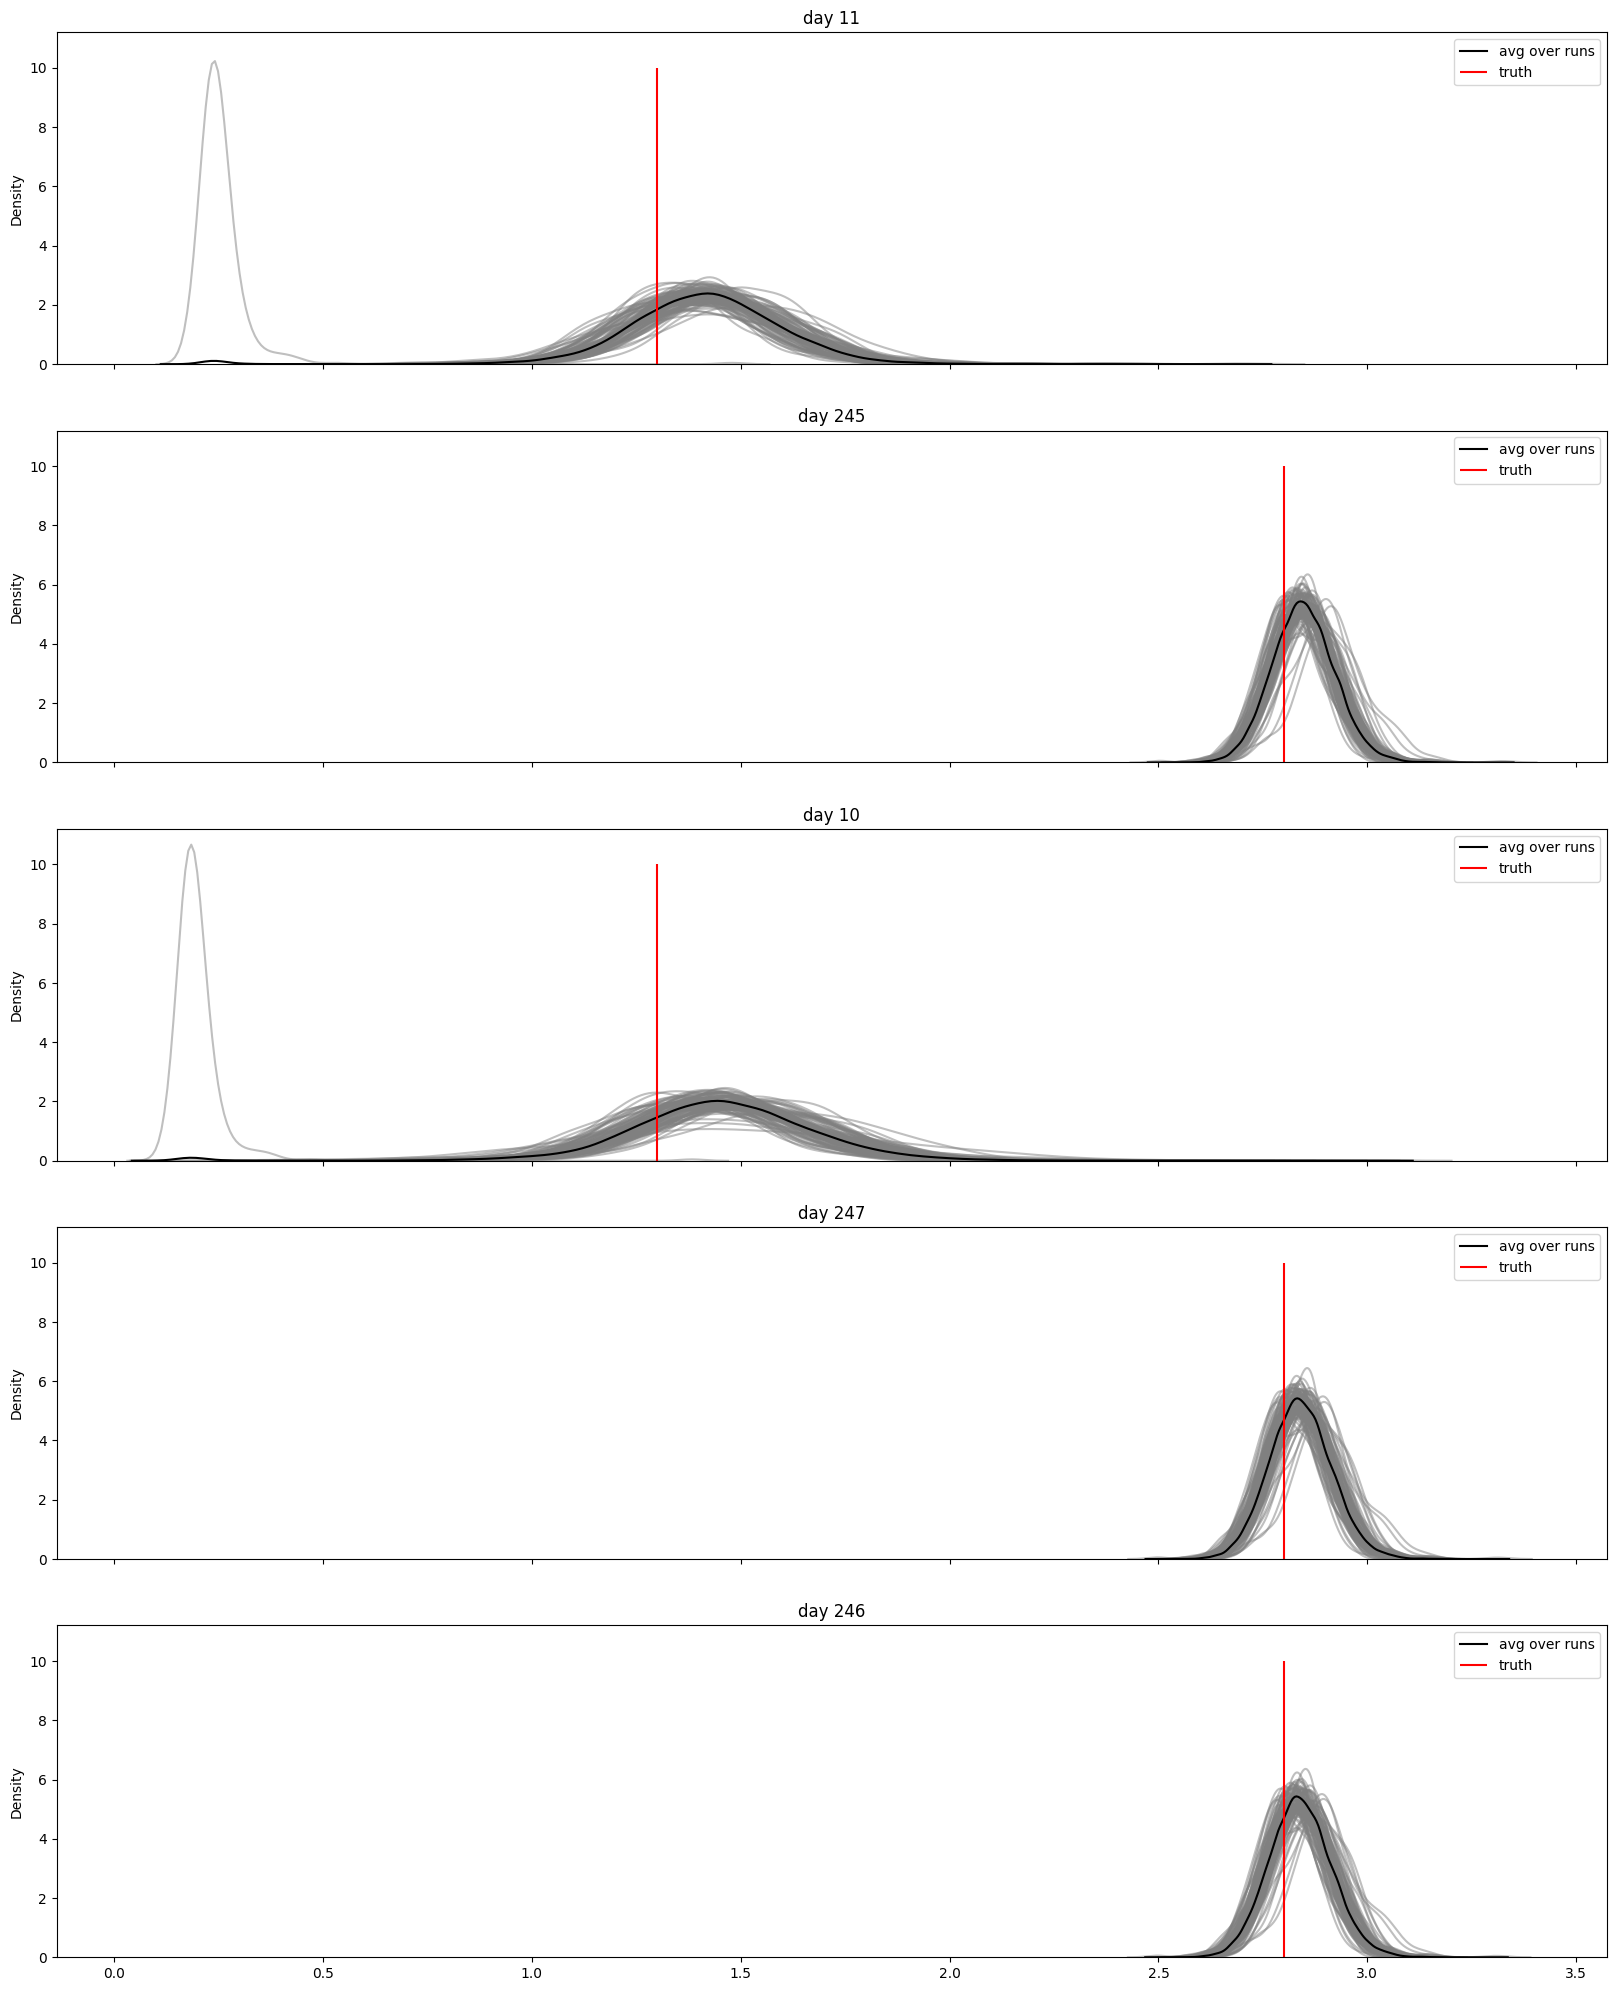

In [28]:
fig, axs = plt.subplots(5, figsize=(20,25), sharex = True, sharey=True)
for i, ax in enumerate(axs.flat):
    data = np.array(blah_list)[:,i,:]
    for j in range(data.shape[0]):  # plot kde for each run on day i
        sns.kdeplot(data=data[j,:], color='gray', alpha=0.5, ax=ax)
    sns.kdeplot(data=data[:,:].flatten(), color='black', ax=ax, label='avg over runs')
    ax.set_title(f"day {best_scores_idx[i]}")
    ax.vlines(truth[best_scores_idx[i]], 0, 10, color='red', label='truth')
    ax.legend()

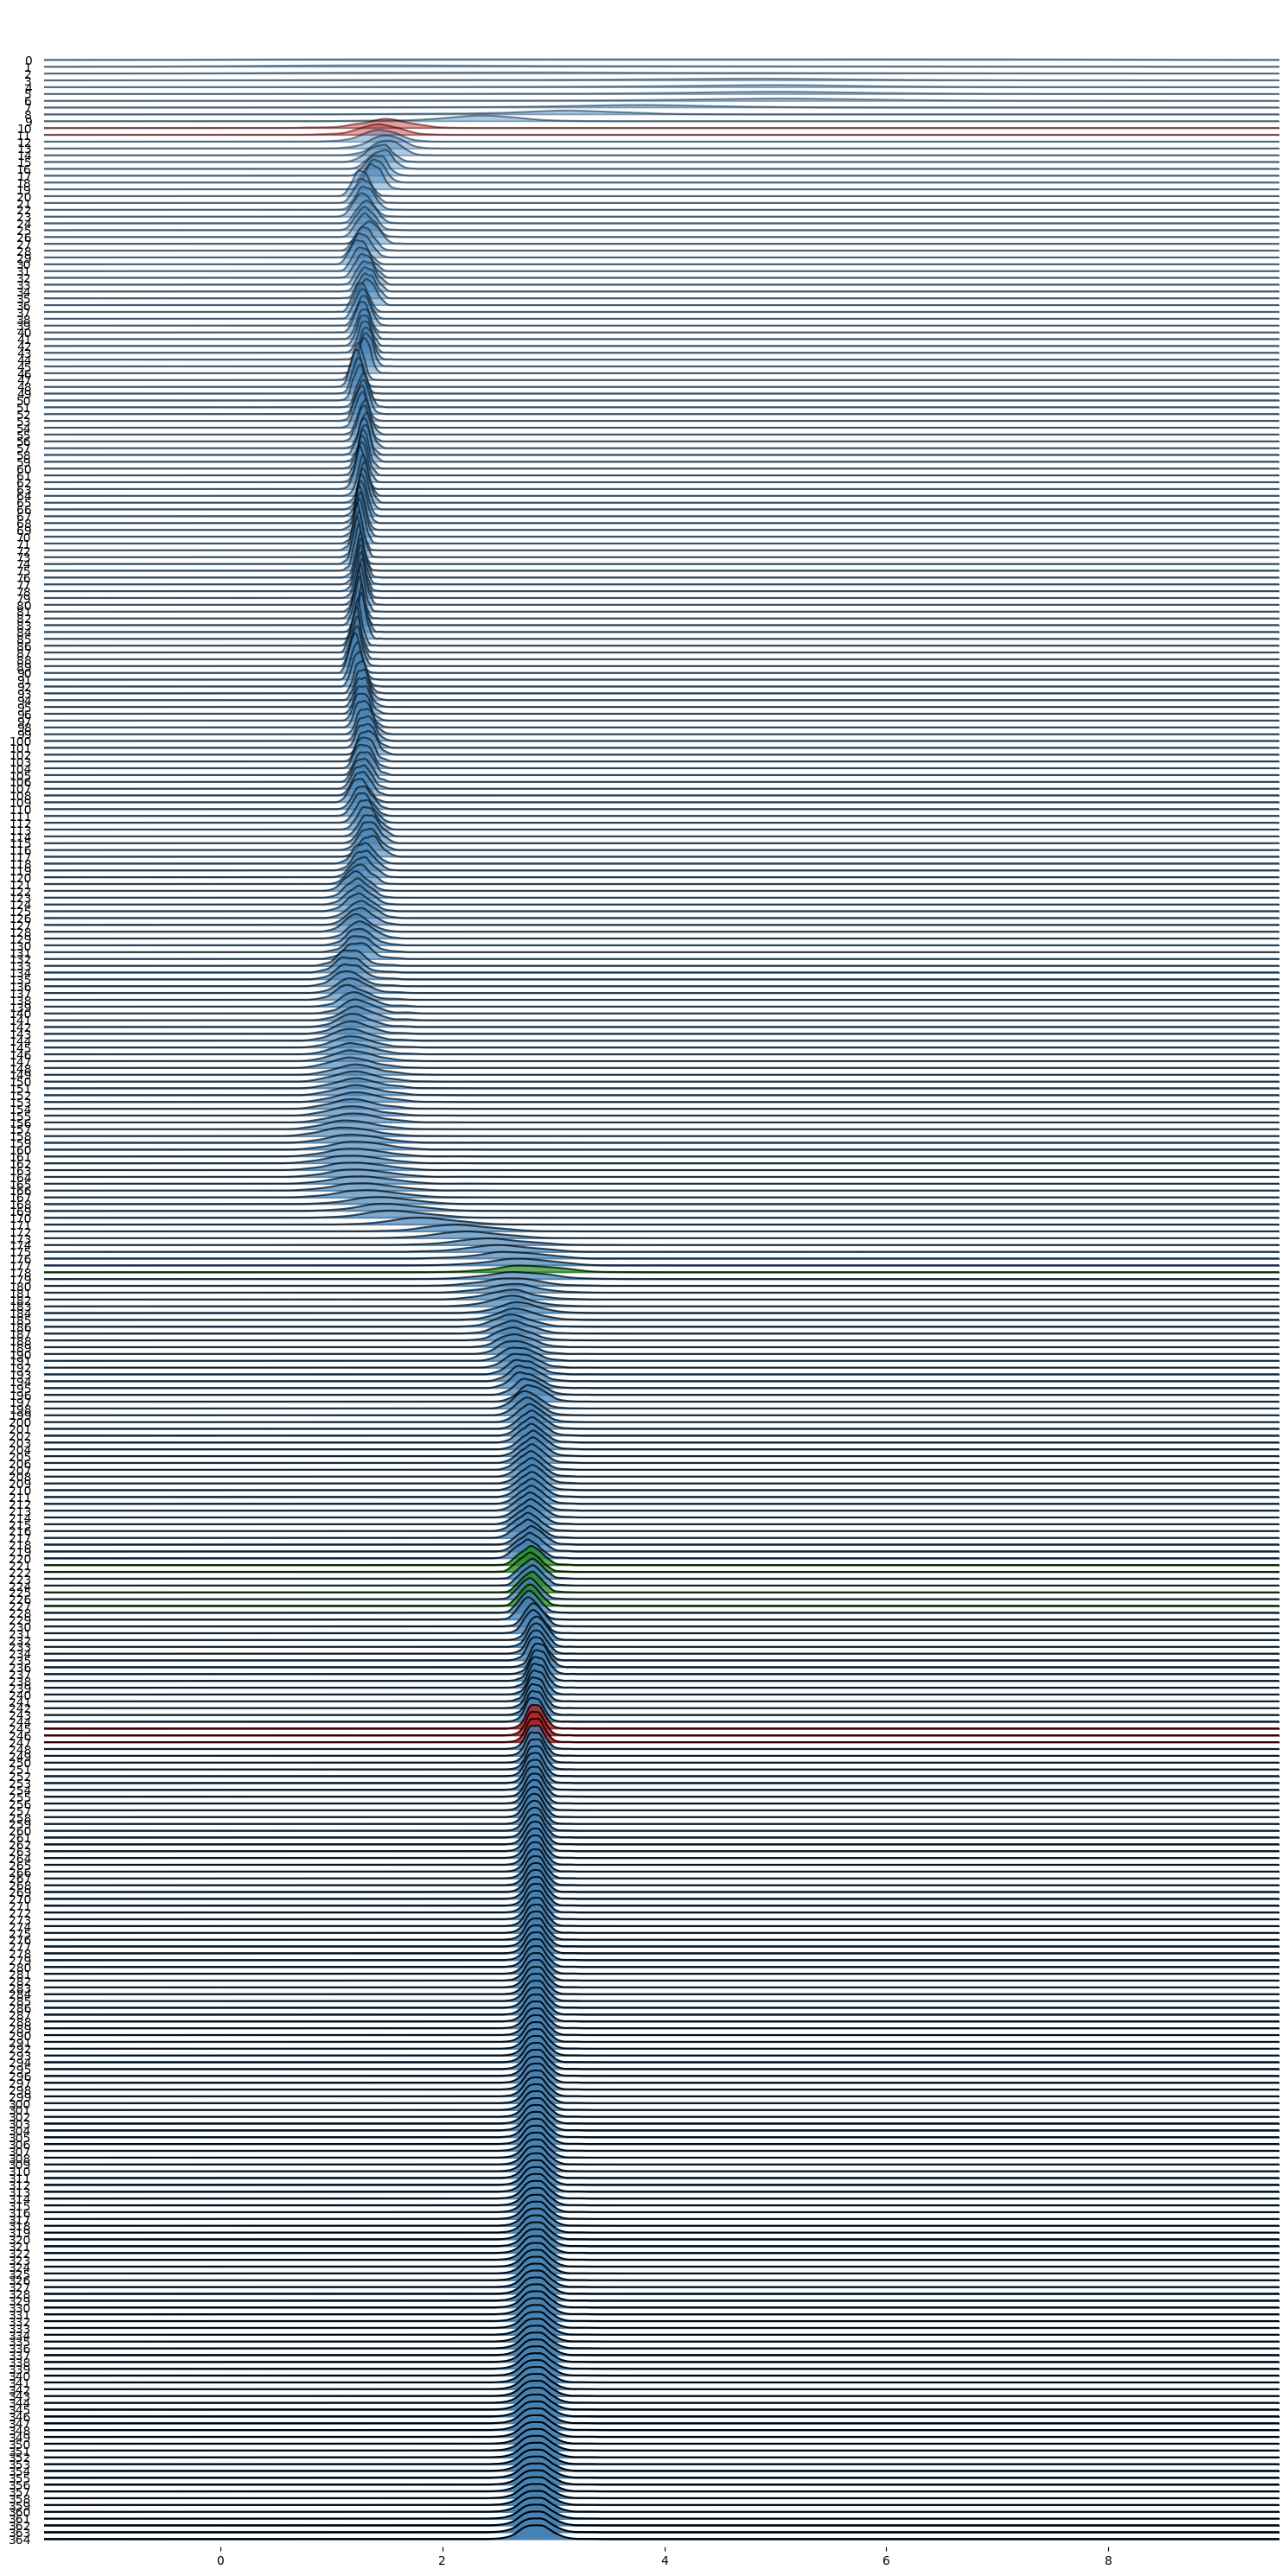

In [29]:
import joypy

df = pd.DataFrame(post_rts.T)

colors = ["#4682B4"] * 365
for idx in best_scores_idx:
    colors[idx] = "#B22222"

fig, axes = joypy.joyplot(df, fade=True, figsize=(15,30), color=colors)

#### Score based on days where the truth is exactly in the middle of the percentile
This is dumb and slow. There's probably a faster and better way to do this. How about looking in `percentiles` for days that are close to 0

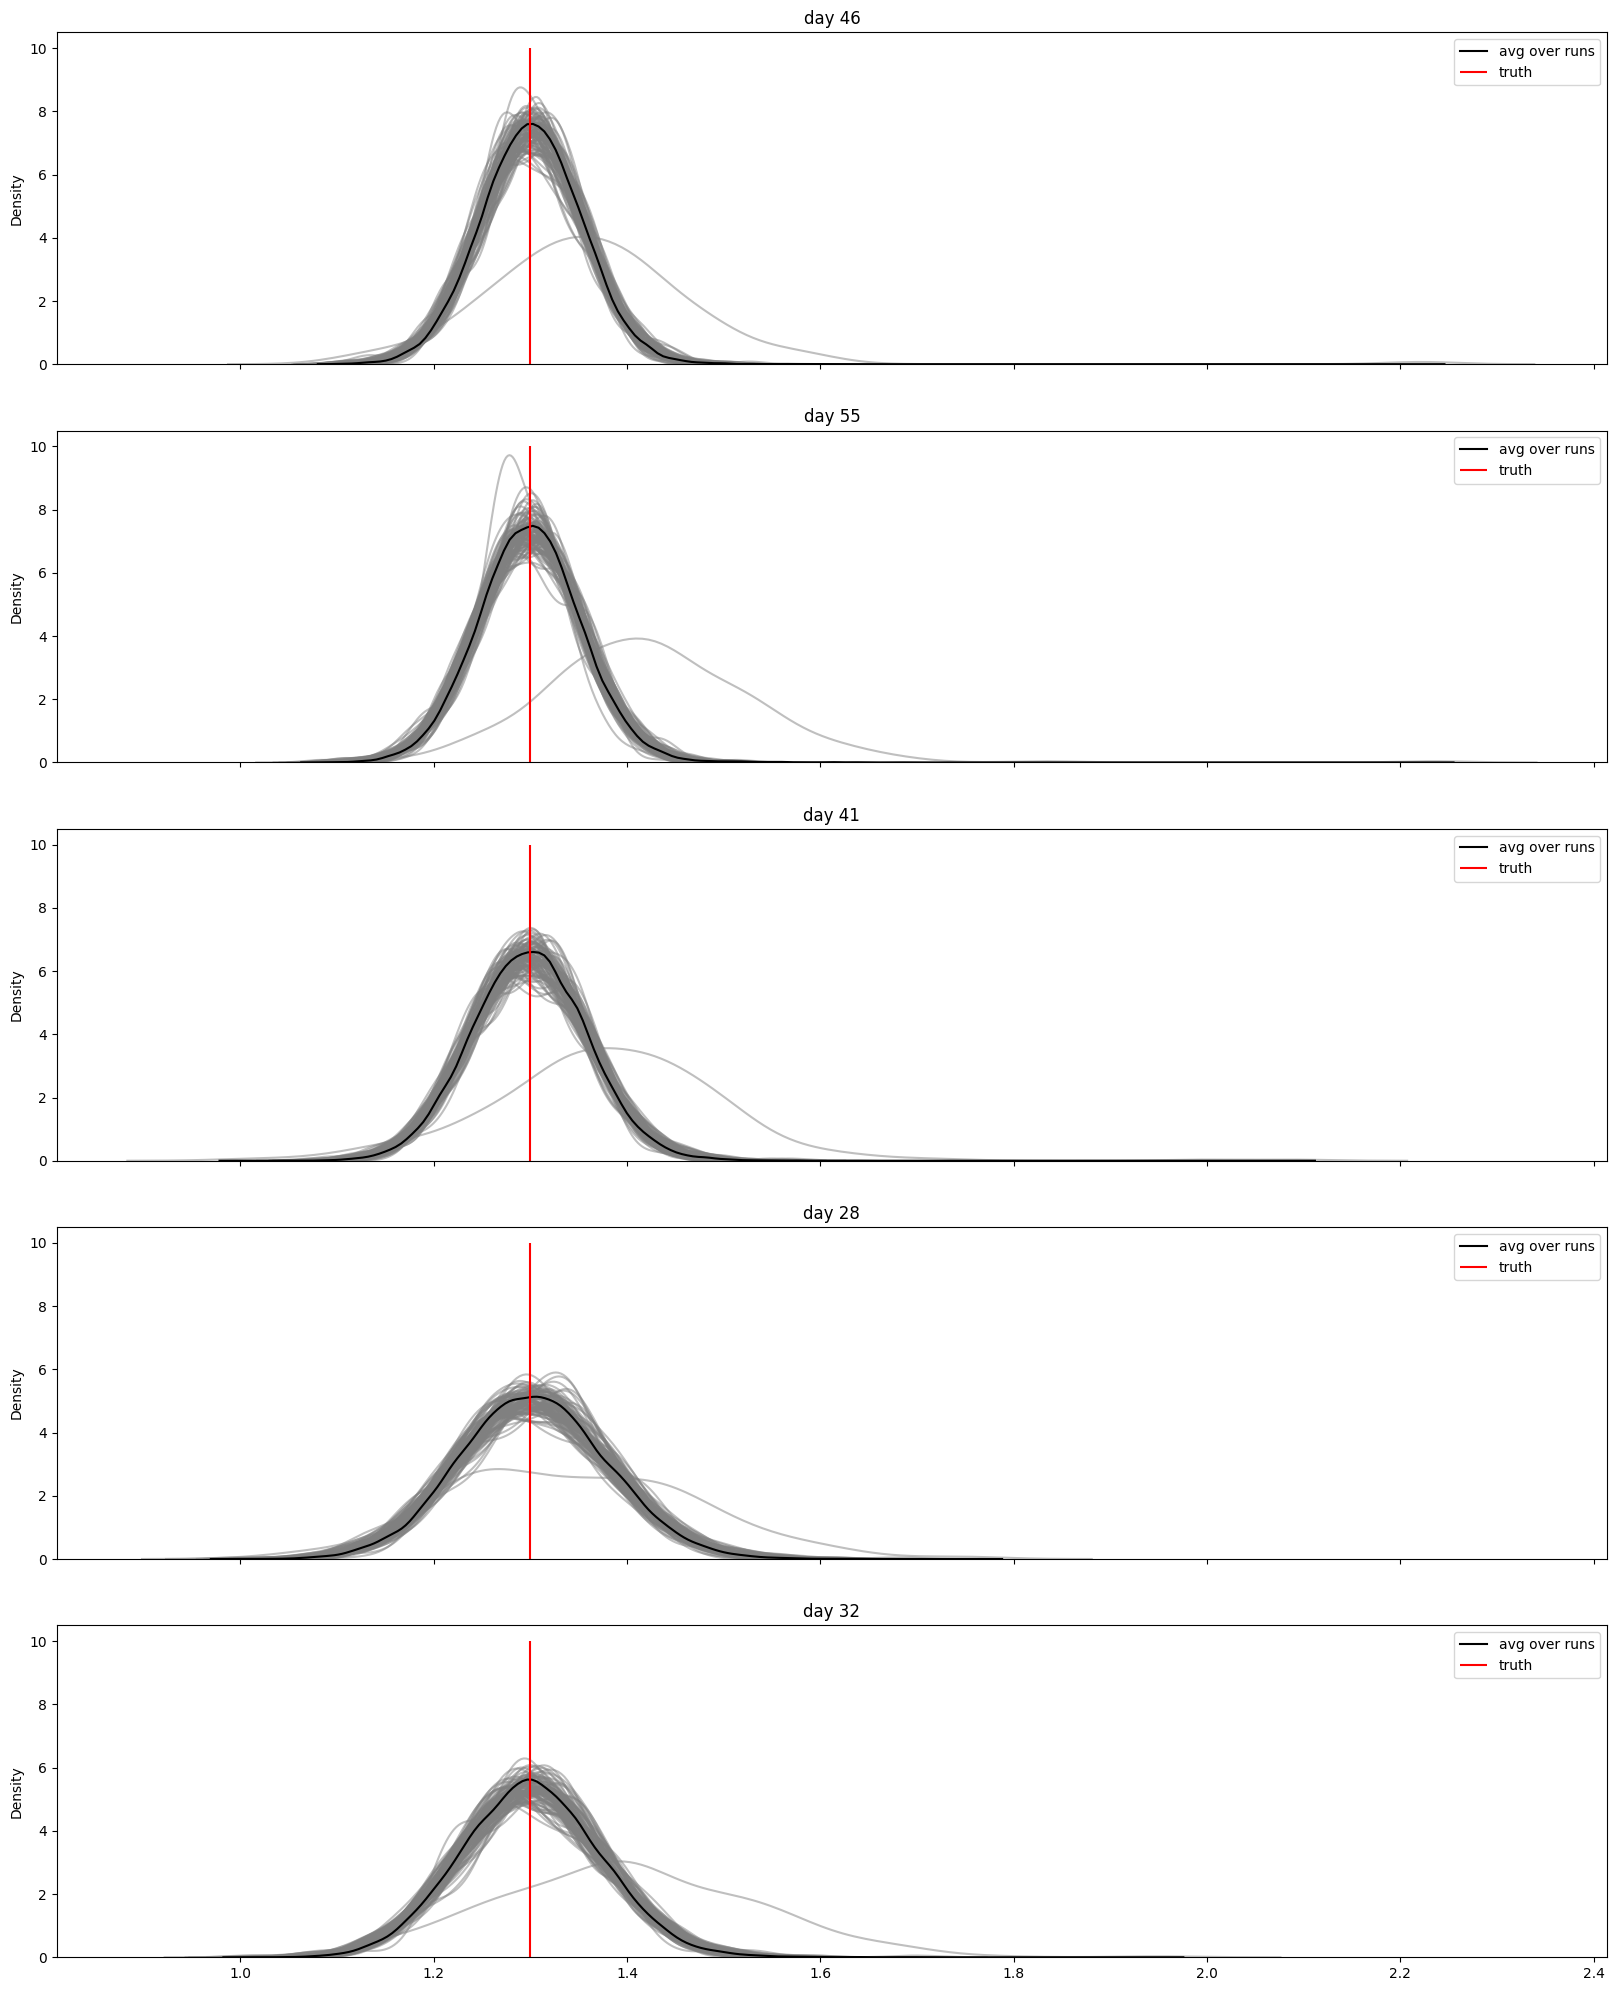

In [19]:
percentiles_mean_run = np.mean(percentiles, axis=0)
best_scores_idx = np.argsort(percentiles_mean_run)[:5]

blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_idx,:])

fig, axs = plt.subplots(5, figsize=(20,25), sharex = True, sharey=True)
for i, ax in enumerate(axs.flat):
    data = np.array(blah_list)[:,i,:]
    for j in range(data.shape[0]):  # plot kde for each run on day i
        sns.kdeplot(data=data[j,:], color='gray', alpha=0.5, ax=ax)
    sns.kdeplot(data=data[:,:].flatten(), color='black', ax=ax, label='avg over runs')
    ax.set_title(f"day {best_scores_idx[i]}")
    ax.vlines(truth[best_scores_idx[i]], 0, 10, color='red', label='truth')
    ax.legend()

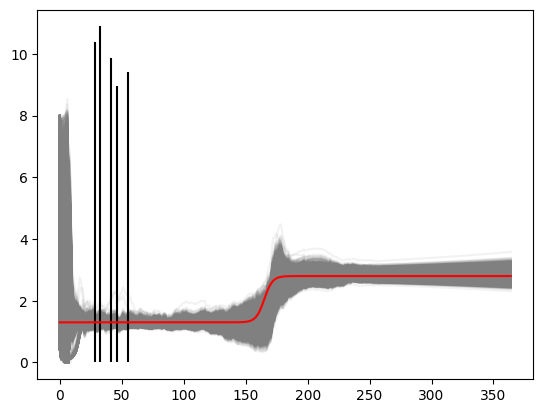

In [20]:
fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.1)

for day in best_scores_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='black', label='last epi day')
ax.plot(truth, color='r')

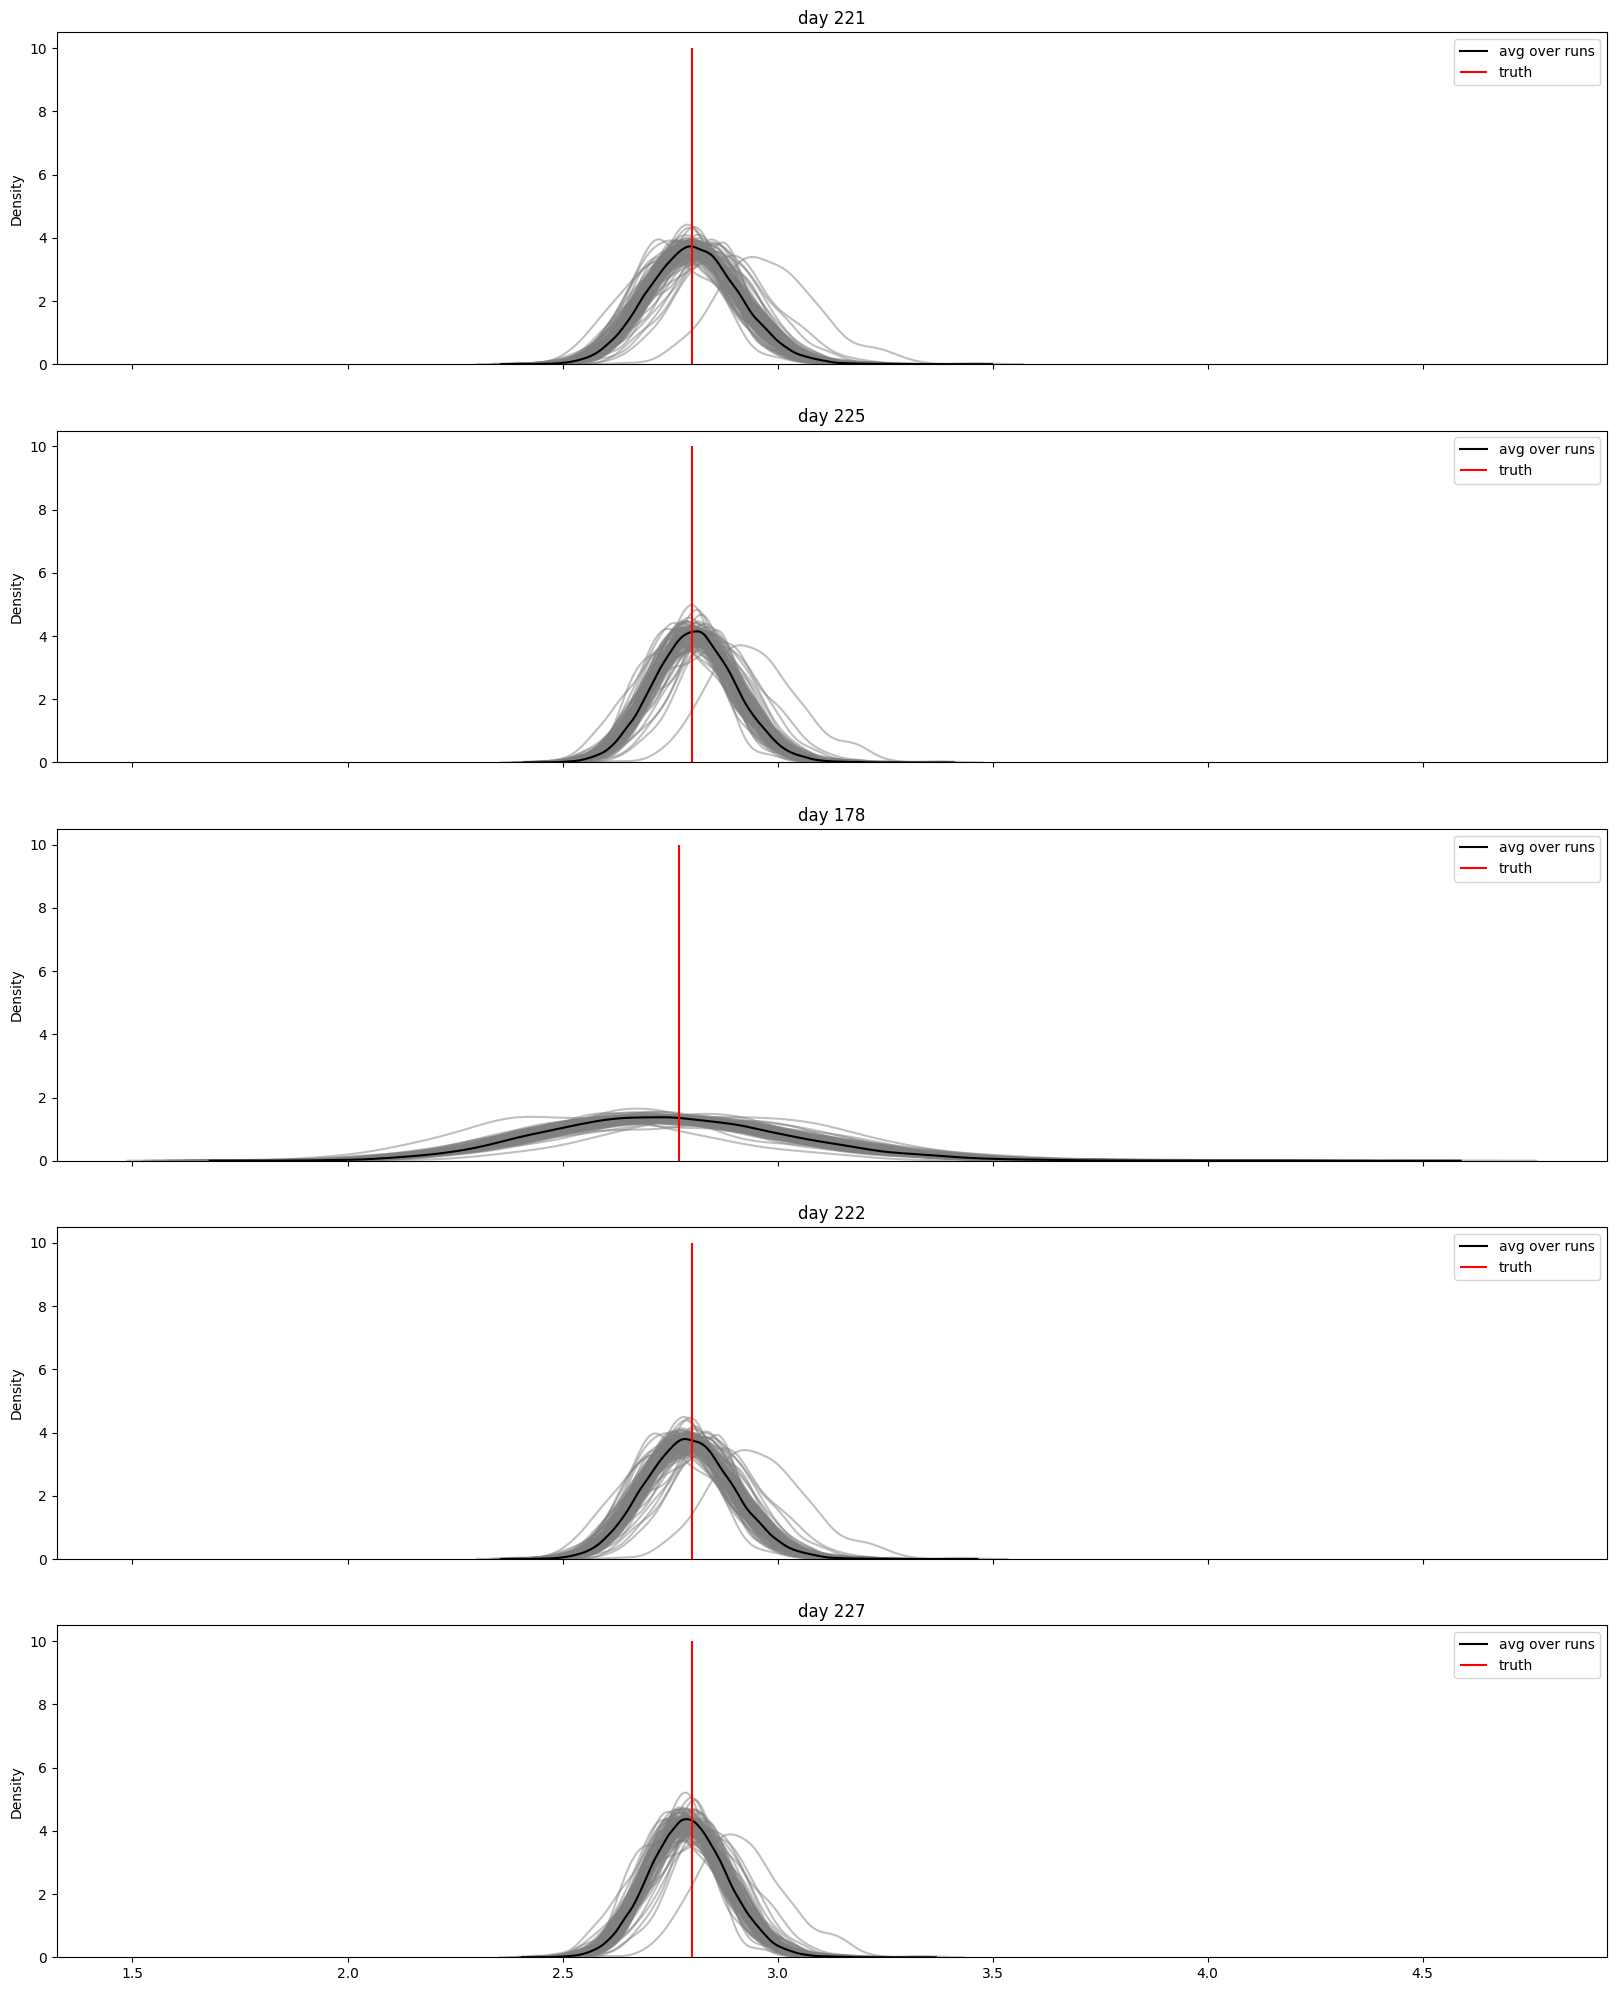

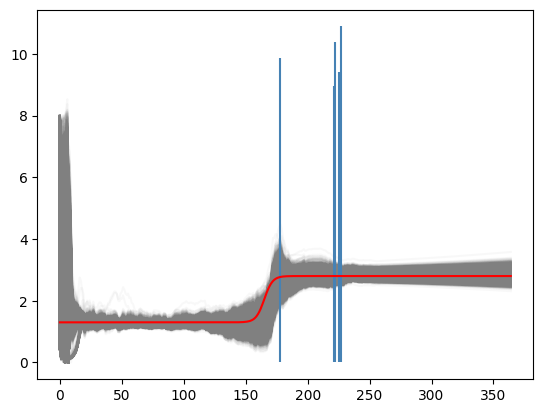

In [21]:
best_scores_after_midpoint_idx = eakf.data.midpoint + np.argsort(percentiles_mean_run[eakf.data.midpoint:])[:5]

blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_after_midpoint_idx,:])

fig, axs = plt.subplots(5, figsize=(20,25), sharex = True, sharey=True)
for i, ax in enumerate(axs.flat):
    data = np.array(blah_list)[:,i,:]
    for j in range(data.shape[0]):  # plot kde for each run on day i
        sns.kdeplot(data=data[j,:], color='gray', alpha=0.5, ax=ax)
    sns.kdeplot(data=data[:,:].flatten(), color='black', ax=ax, label='avg over runs')
    ax.set_title(f"day {best_scores_after_midpoint_idx[i]}")
    ax.vlines(truth[best_scores_after_midpoint_idx[i]], 0, 10, color='red', label='truth')
    ax.legend()

fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.05)

for day in best_scores_after_midpoint_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='black', label='last epi day')
ax.plot(truth, color='r')


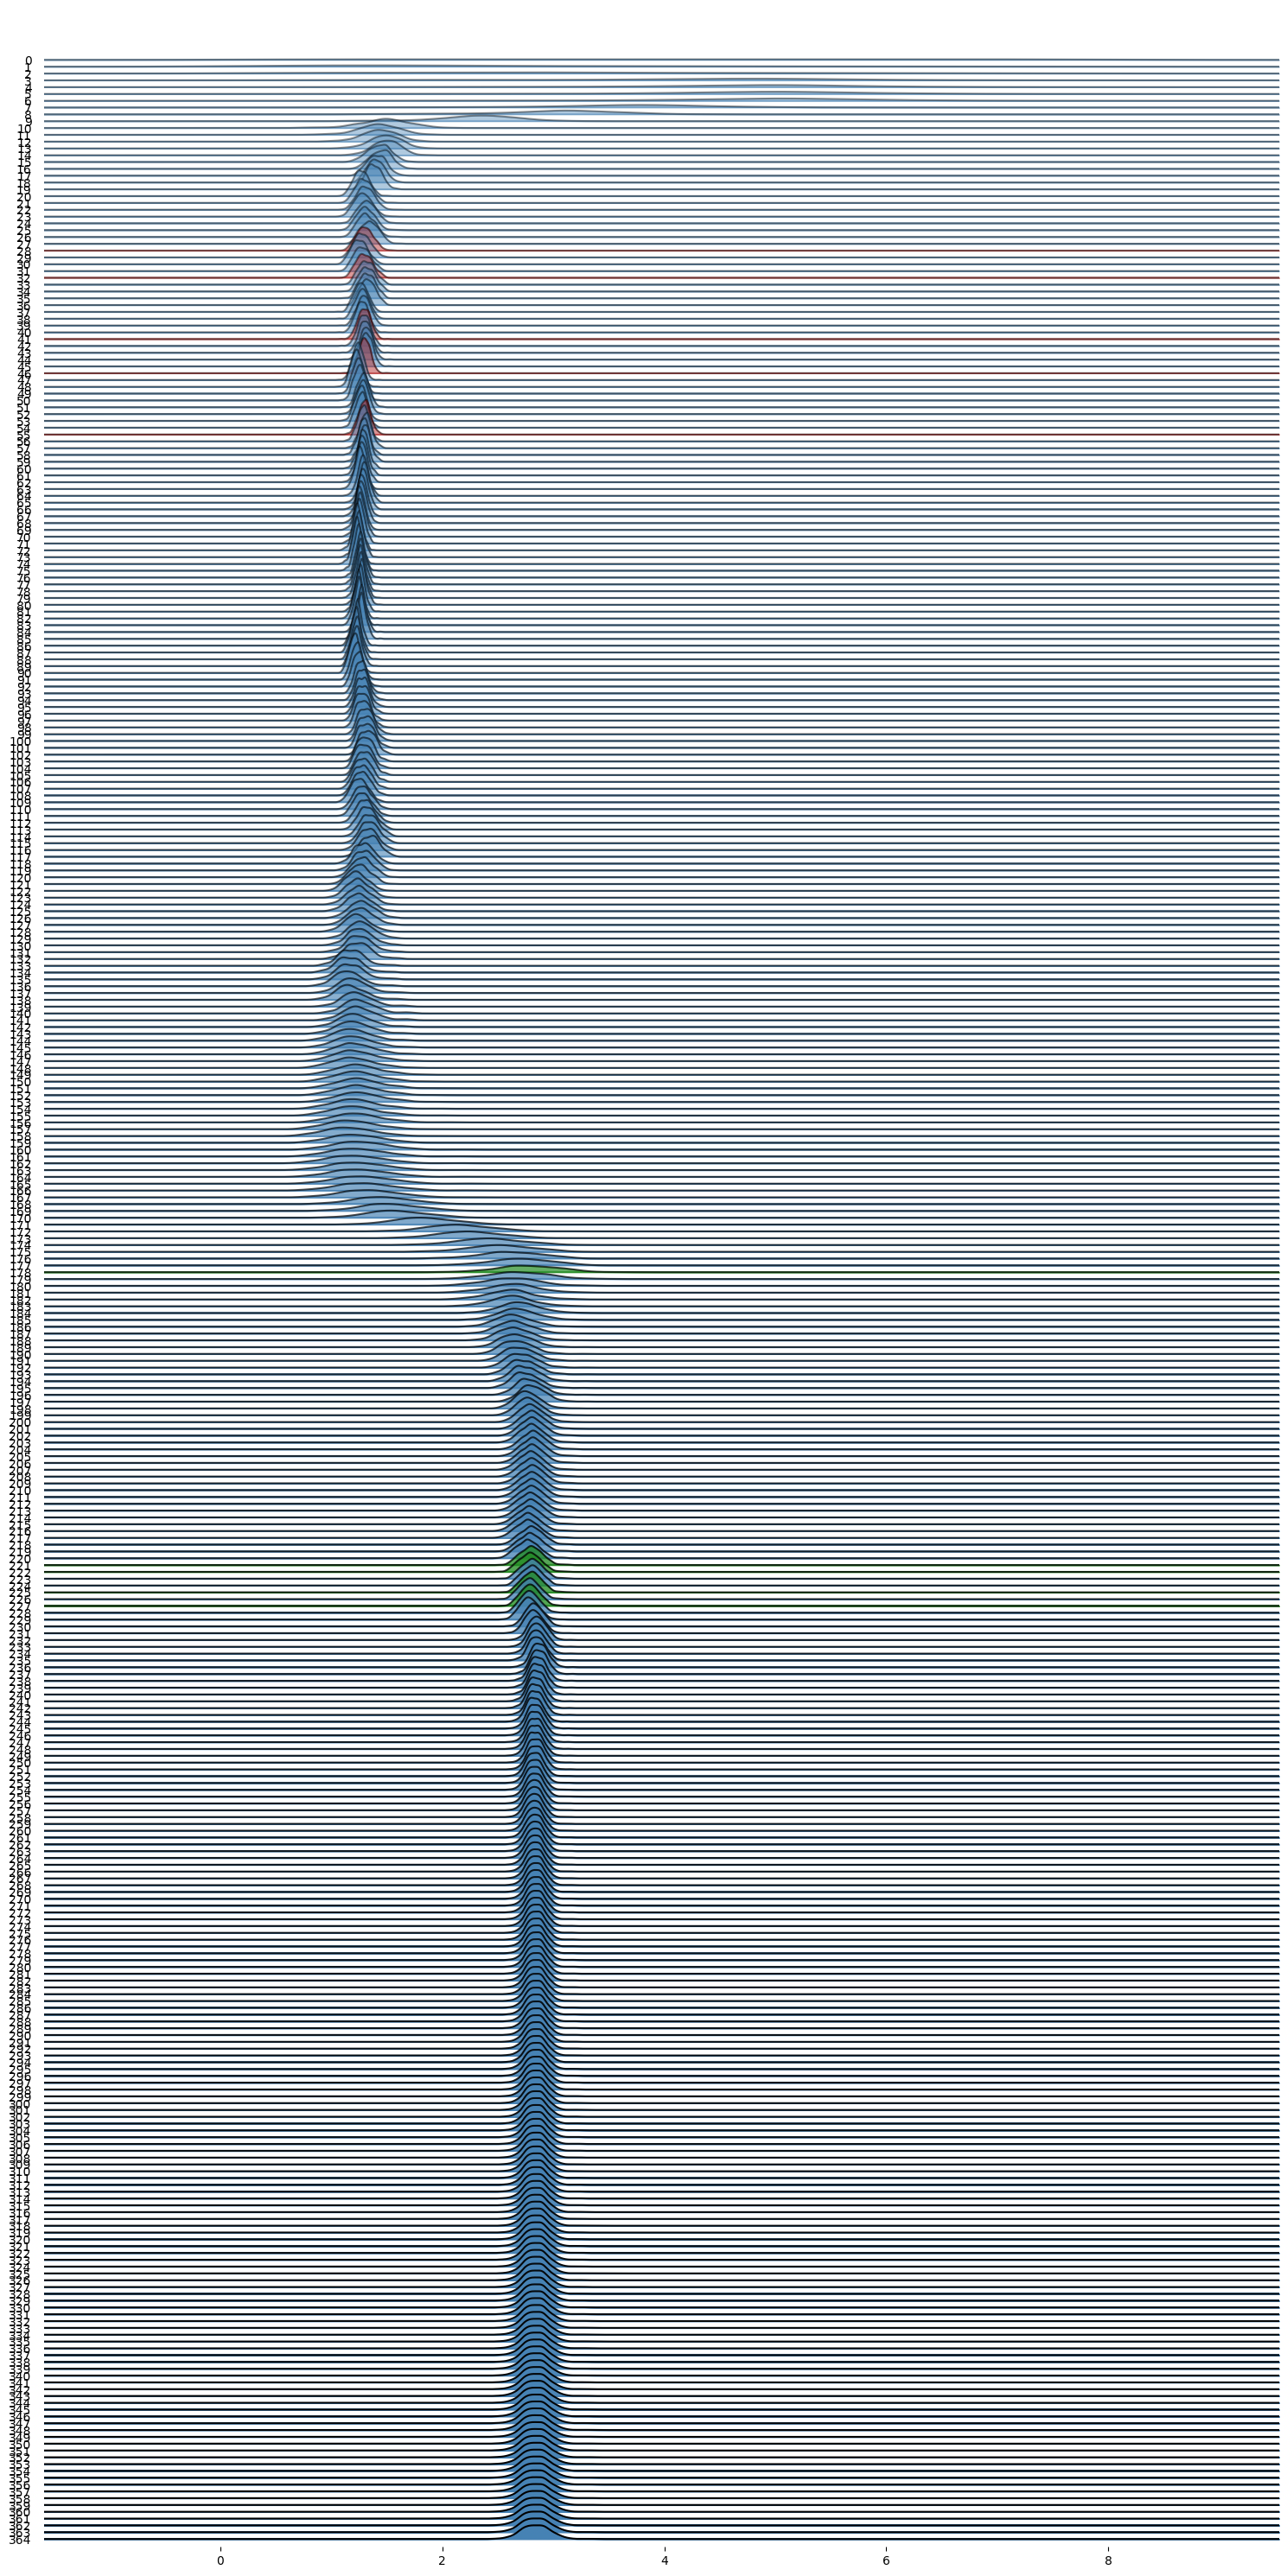

In [22]:
import joypy

df = pd.DataFrame(post_rts.T)

colors = ["#4682B4"] * 365
for idx in best_scores_idx:
    colors[idx] = "#B22222"
for idx in best_scores_after_midpoint_idx:
    colors[idx] = "#228B22"

fig, axes = joypy.joyplot(df, fade=True, figsize=(15,30), color=colors)

### 3. CRPS

In [78]:
def crps(observation, ensembles):
    """
    Calculate the Continuous Ranked Probability Score (CRPS).

    Parameters:
        observation (float): The observed value.
        ensembles (array_like): The posterior of the prediction. It should be 
            a 1D array representing the ensemble members of the filter on one day

    Returns:
        crps_score (float): The CRPS score.
    """
    hist, bins = np.histogram(ensembles, bins=len(np.unique(ensembles)))
    cdf = np.cumsum(hist/ensembles.shape[0])
    crps_score = 0
    for i,x in enumerate(bins[1:]):
        crps_score += (cdf[i] - np.heaviside(x-y, 0.5))**2 * (bins[i] - bins[i-1])

    return crps_score

# Example usage:
# Suppose observation is 10 and forecasted CDF values are [0.1, 0.3, 0.5, 0.7, 0.9]
observation = truth[250]
prediction_cdf = post_rts[250,:]

# Calculate CRPS
score = crps(observation, prediction_cdf)
print("CRPS:", score)

CRPS: 0.026152252091040426


In [81]:
crps_all_runs = []
for run in tqdm(range(100)):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle(file)
    
    truth = eakf.data.beta * eakf.data.t_I
    post_rts = np.sort(np.array([θ.beta * θ.t_I for θ in eakf.θ_list]), axis=1)
    
    scores = []
    for i, obs in enumerate(truth):
        scores.append(crps(obs, post_rts[i,:]))
    
    crps_all_runs.append(scores)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]


Average CRPS over run

In [85]:
np.argsort(np.mean(crps_all_runs, axis=0))[:5]

array([231, 254, 257, 244, 227])

### 4. RMSE

In [97]:
rmse = np.mean(np.square((post_rts - truth[:,np.newaxis])), axis=1)
np.argsort(rmse)[:5]


array([66, 65, 64, 67, 60])